# Exploratory Analysis (database connected)
### Top 3 items for store_id = [12, 15, 11, 14]

In [36]:
import warnings
# Ignore the warning about the version of SQLAlchemy
warnings.filterwarnings('ignore', message="pandas only supports SQLAlchemy connectable.*")

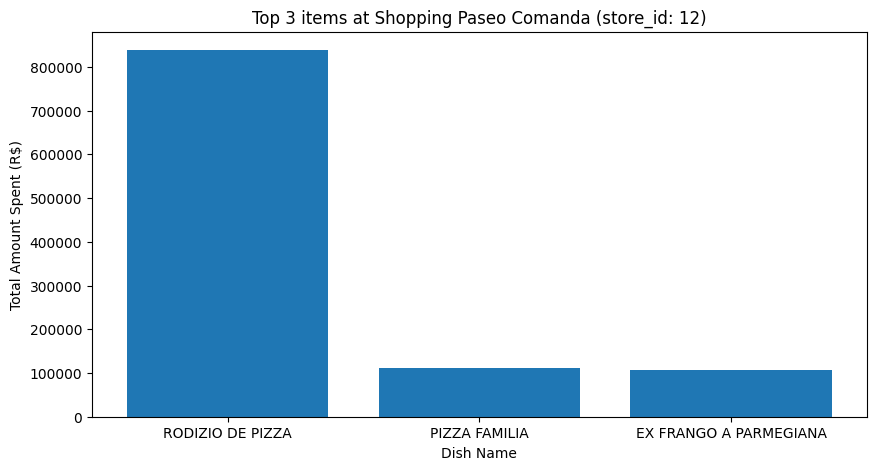

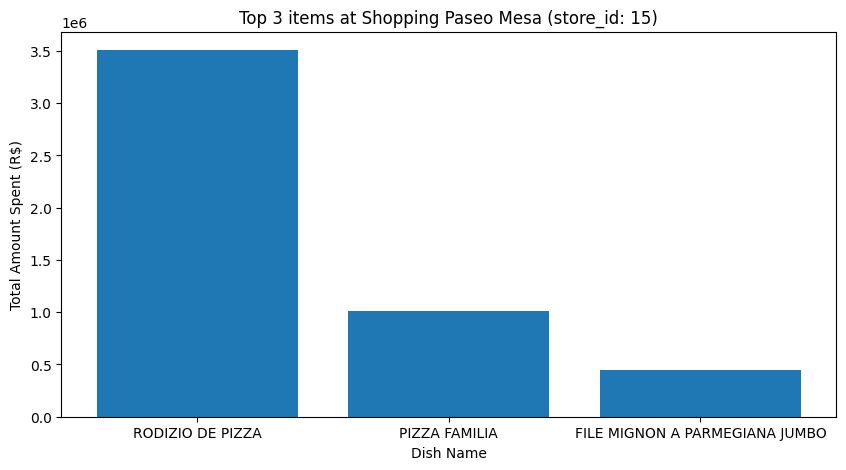

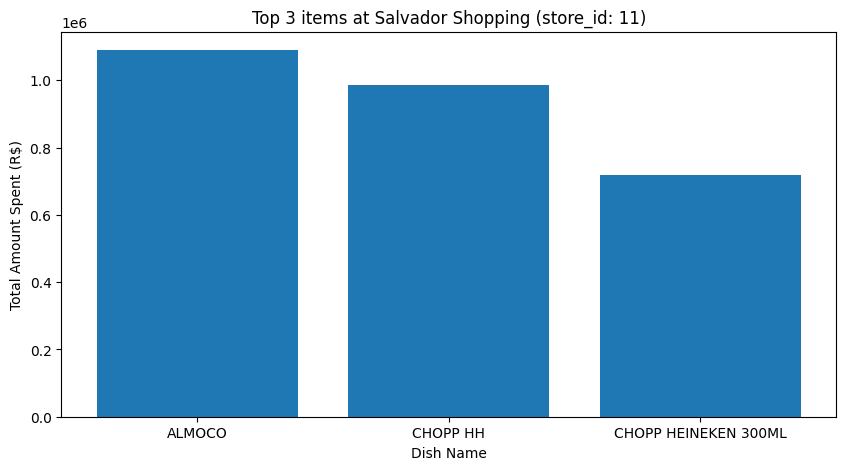

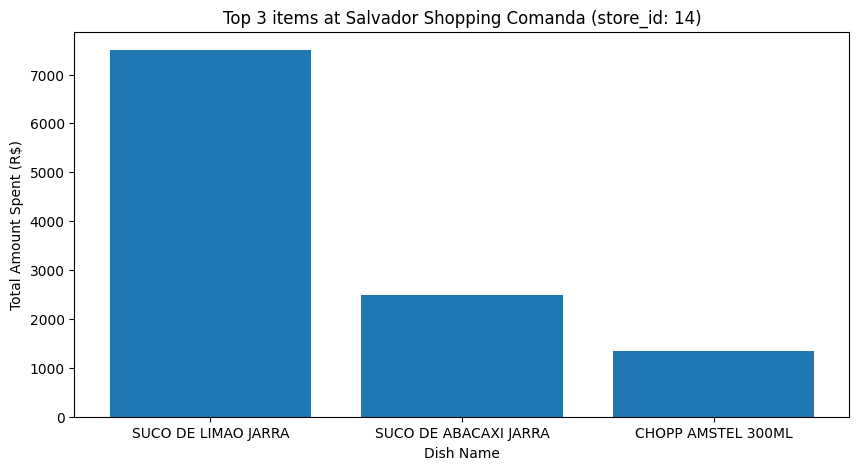

In [37]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

# Database connection parameters
db_params = {
    'dbname': 'payby',
    'user': 'postgres',
    'password': '2458',
    'host': 'localhost',
    'port': '5432'
}

def get_all_store_ids():
    query = "SELECT id FROM core_store;"
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    
    try:
        cur.execute(query)
        store_ids = cur.fetchall()
        store_ids = [store_id[0] for store_id in store_ids]
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        store_ids = []
    finally:
        cur.close()
        conn.close()
    return store_ids

def get_store_name(store_id):
    query = f"SELECT name FROM core_store WHERE id = {store_id};"
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    
    try:
        cur.execute(query)
        store_name = cur.fetchone()[0]
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        store_name = None
    finally:
        cur.close()
        conn.close()
    return store_name

# Function to retrieve 'items' from the 'core_ticket' table
# The 'items' column is a JSONB type
def get_items_from_db(store_id):
    query = f"SELECT items FROM core_ticket WHERE store_id = {store_id};"
    conn = psycopg2.connect(**db_params)
    try:
        df = pd.read_sql(query, conn)
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        df = pd.DataFrame()
    finally:
        conn.close()
    return df

# Function to parse items and calculate the top 3 items
def get_top_3_items(df):
    d = {}
    order_list = df['items']
    for order in order_list:
        for item_info in order:
            try:
                item_name = item_info['name']
                item_value = float(item_info['value'])
                item_amount = float(item_info['amount'])
                if item_name not in d:
                    d[item_name] = item_value * item_amount
                else:
                    d[item_name] += item_value * item_amount
            except:
                pass
    sorted_d = sorted(d.items(), key=lambda x: x[1], reverse=True)
    top_3 = sorted_d[:3]

    return top_3

#intersted_store_ids = get_all_store_ids()
intersted_store_ids = [12, 15, 11, 14]
# Loop through the store_ids and get the top 3 items
# print the top 3 items for each store
for store_id in intersted_store_ids:
    df = get_items_from_db(store_id)
    if not df.empty:
        top_3 = get_top_3_items(df)
        store_name = get_store_name(store_id)
        # plot the top 3 items
        plt.figure(figsize=(10, 5))
        plt.xlabel('Dish Name')
        plt.ylabel('Total Amount Spent (R$)')
        plt.title(f'Top 3 items at {store_name} (store_id: {store_id})')   
        plt.bar(range(len(top_3)), [val[1] for val in top_3], align='center')
        plt.xticks(range(len(top_3)), [val[0] for val in top_3])
        plt.show()
    else:
        print(f"No items found for store_id: {store_id}")


### Best Day for store_id = [12, 15, 11, 14]

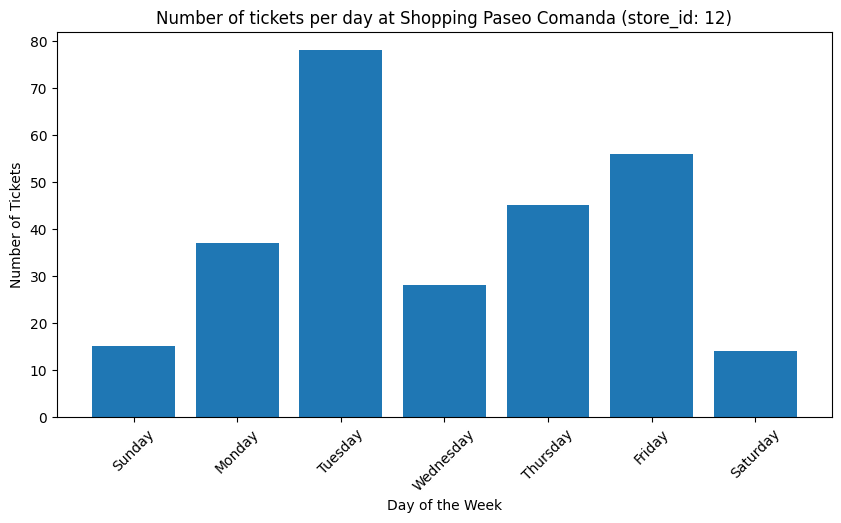

The best day to visit Shopping Paseo Comanda (store_id: 12) is Tuesday.


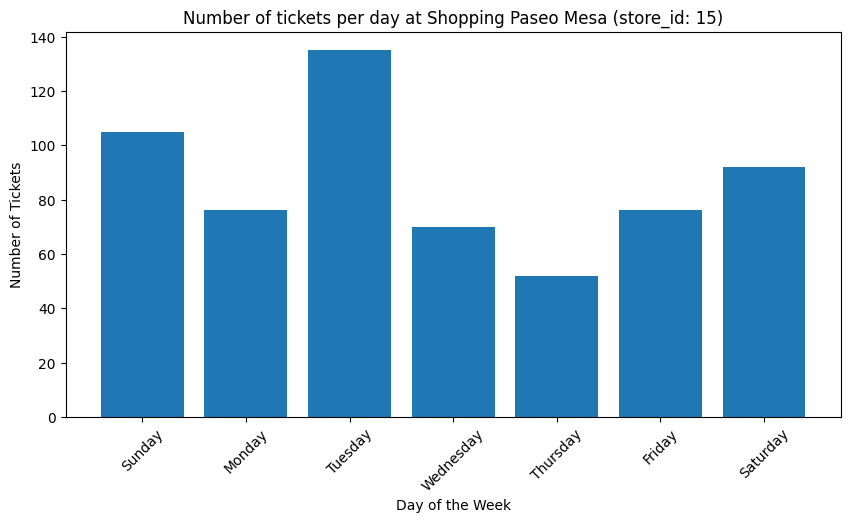

The best day to visit Shopping Paseo Mesa (store_id: 15) is Tuesday.


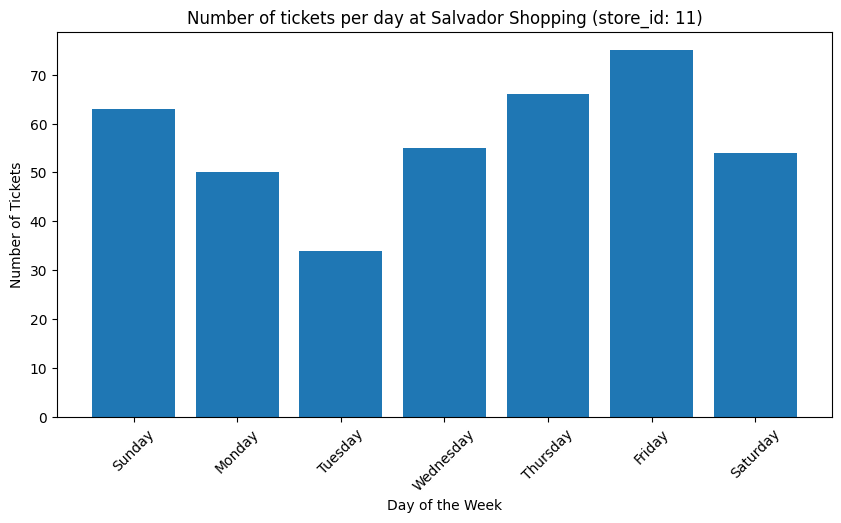

The best day to visit Salvador Shopping (store_id: 11) is Friday.


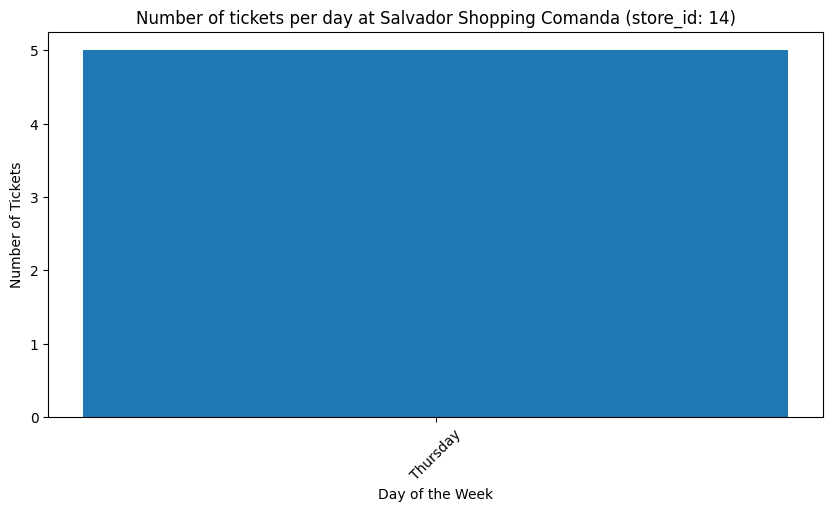

The best day to visit Salvador Shopping Comanda (store_id: 14) is Thursday.


In [38]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

# get the total number of tickets per day of the week
def get_tickets_per_day(store_id):
    query = f"""
    SELECT EXTRACT(DOW FROM dt_created) AS day_of_week, COUNT(*) AS count
    FROM core_ticket
    WHERE store_id = {store_id}
    GROUP BY day_of_week
    ORDER BY day_of_week;
    """
    conn = psycopg2.connect(**db_params)
    try:
        df = pd.read_sql(query, conn)
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        df = pd.DataFrame()
    finally:
        conn.close()
    return df

day_names = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
def get_best_day_to_visit(df):
    df['day_name'] = df['day_of_week'].map(day_names)
    best_day = df[df['count'] == df['count'].max()]['day_name'].values[0]
    return best_day

def plot_tickets_per_day(df, store_name, store_id):
    df['day_name'] = df['day_of_week'].map(day_names)
    
    plt.figure(figsize=(10, 5))
    plt.bar(df['day_name'], df['count'], align='center')
    plt.xlabel('Day of the Week')
    plt.ylabel('Number of Tickets')
    plt.title(f'Number of tickets per day at {store_name} (store_id: {store_id})')
    plt.xticks(rotation=45)
    plt.show()

#intersted_store_ids = get_all_store_ids()
intersted_store_ids = [12, 15, 11, 14]
for store_id in intersted_store_ids:
    df = get_tickets_per_day(store_id)
    if not df.empty:
        best_day = get_best_day_to_visit(df)
        store_name = get_store_name(store_id)
        plot_tickets_per_day(df, store_name, store_id)
        print(f"The best day to visit {store_name} (store_id: {store_id}) is {best_day}.")
    else:
        print(f"No tickets found for store_id: {store_id}.")


### Busiest Times for store_id = [12, 15, 11, 14]

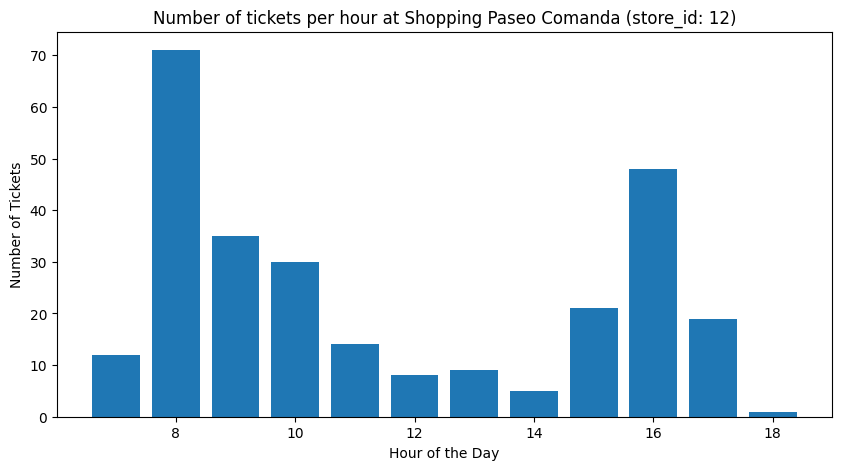

The busiest hour at Shopping Paseo Comanda (store_id: 12) is 8:00.


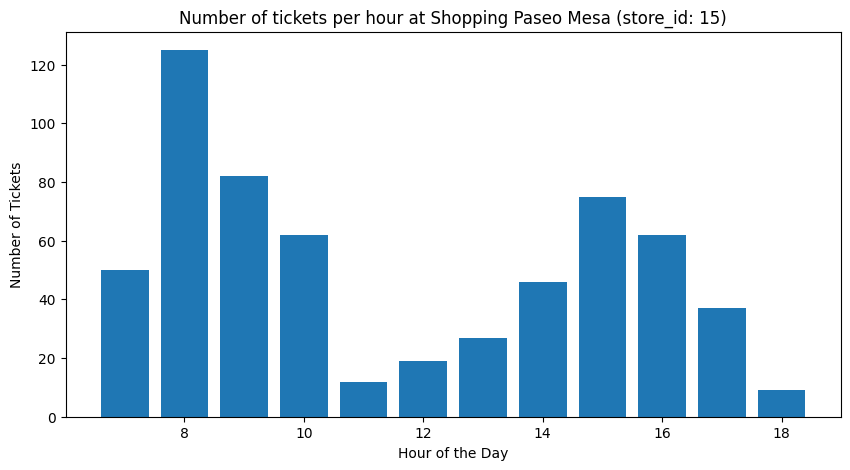

The busiest hour at Shopping Paseo Mesa (store_id: 15) is 8:00.


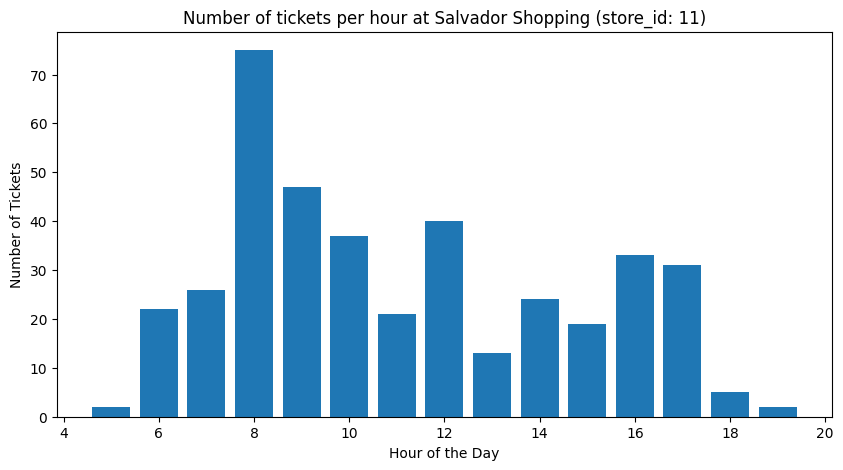

The busiest hour at Salvador Shopping (store_id: 11) is 8:00.


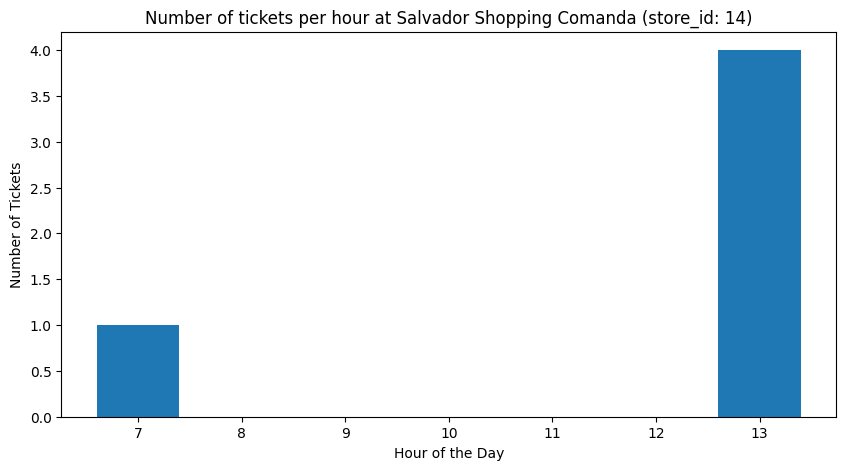

The busiest hour at Salvador Shopping Comanda (store_id: 14) is 13:00.


In [39]:
# print the ts_created column of the core_ticket table
def get_ticket_creation_times(store_id):
    query = f'''SELECT EXTRACT(HOUR FROM ts_created) AS hour, COUNT(*) 
    AS count FROM core_ticket 
    WHERE store_id = {store_id} 
    GROUP BY hour ORDER BY hour;
    '''
    conn = psycopg2.connect(**db_params)
    try:
        df = pd.read_sql(query, conn)
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        df = pd.DataFrame()
    finally:
        conn.close()
    return df

def plot_tickets_per_hour(df, store_name, store_id):
    plt.figure(figsize=(10, 5))
    plt.bar(df['hour'], df['count'], align='center')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Tickets')
    plt.title(f'Number of tickets per hour at {store_name} (store_id: {store_id})')
    plt.show()

#intersted_store_ids = get_all_store_ids()
intersted_store_ids = [12, 15, 11, 14]
# plot the number of tickets created per hour
# and print the buiziets hour of the day
for store_id in intersted_store_ids:
    df = get_ticket_creation_times(store_id)
    if not df.empty:
        busiest_hour = df[df['count'] == df['count'].max()]['hour'].values[0]
        store_name = get_store_name(store_id)
        plot_tickets_per_hour(df, store_name, store_id)
        print(f"The busiest hour at {store_name} (store_id: {store_id}) is {int(busiest_hour)}:00.")
    else:
        print(f"No tickets found for store_id: {store_id}.")
